In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [513]:
from kid_readout.analysis import archive,cross_spectrum,noise_measurement,resonator,iqnoise
from kid_readout.utils import filters,despike

In [15]:
snms = archive.load_noise_pkl('/data/readout/pkl/2015-09-29_141610_long_timestream.pkl')

In [18]:
len(snms)

16

In [553]:
snm.atten

37.0

In [328]:
detunings = np.vstack([resonator.normalized_s21_to_detuning(snm.normalized_timeseries,snm.resonator_model) for snm in snms]).T
print detunings.shape

KeyboardInterrupt: 

In [337]:
detunings = detunings - detunings.mean(0)

In [339]:
lpdetunings = np.vstack([filters.low_pass_fir(detunings[:,k],cutoff=1/2.**10,decimate_by=2**10) for k in range(16)]).T


In [340]:
print lpdetunings.shape

(32768, 16)


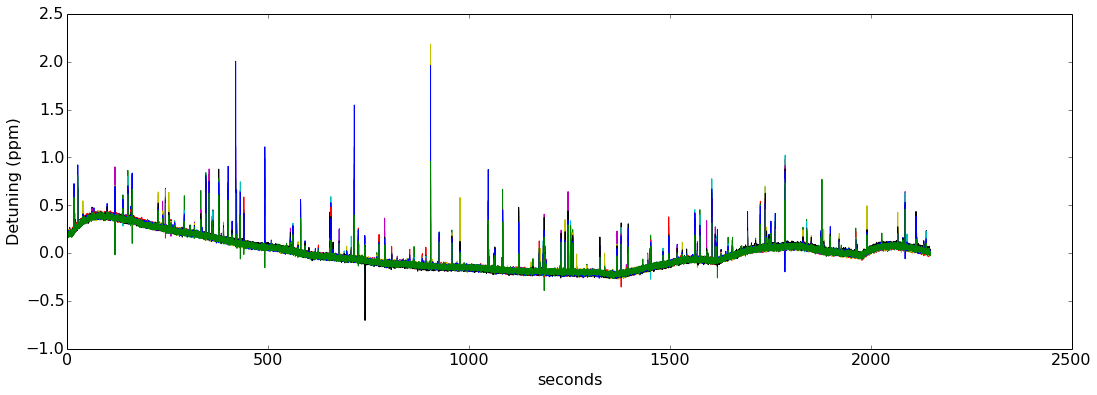

In [551]:
figure(figsize=(18,6))
blah = plot((1/snm.timeseries_sample_rate)*np.arange(lpdetunings.shape[0])*2**10,1e6*lpdetunings)
ylabel('Detuning (ppm)')
xlabel('seconds')

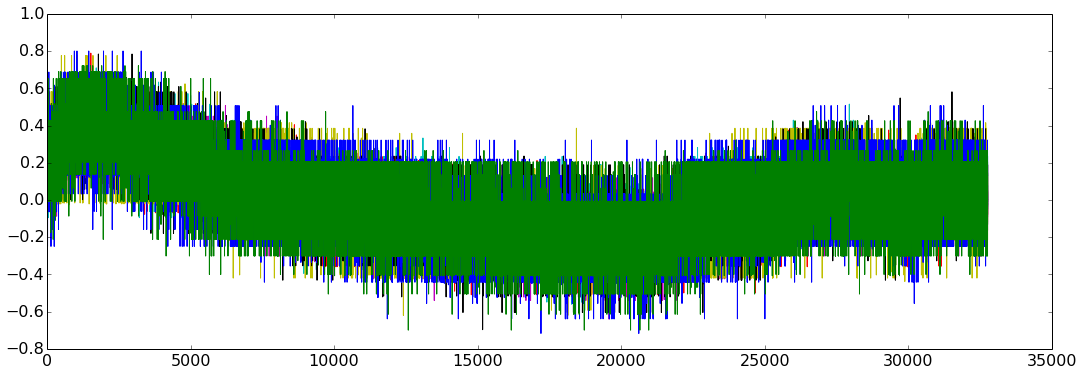

In [552]:
figure(figsize=(18,6))
blah = plot(1e6*clean[::2**10,:])

In [382]:
def remove_common_mode(raw_data):
    datamean = raw_data.mean(1)
    def background(factors):
        return datamean
    def signals(factors):
        return raw_data-background(factors)[:,None]/(1.0*factors)
    def residual(factors):
        sig = signals(factors)
        return np.abs(np.std(sig,axis=0).mean())
    result = scipy.optimize.minimize(residual,np.ones(16),method='L-BFGS-B',
                                             bounds=[(1e-6,1e6) for x in range(16)])
    weights = result['x']
    print result['message']
    return weights

In [465]:
def deglitch_mask_block_mad(ts,thresh=5,mask_extend=50,debug=False):
    median = np.median(ts)
    deviations = np.abs(ts-median)
    mad = np.median(deviations)
    mask = deviations > (mad*thresh)
    if debug:
        plot(deviations)
        plot(mask*deviations.max(),'o')
    new_mask = mask.copy()
    for offset in range(1,mask_extend):
        new_mask[:-offset] |= mask[offset:]
        new_mask[offset:] |= mask[:-offset]
    mask = new_mask
#    mask[:-mask_extend] = (~mask[:-mask_extend] | ~mask[mask_extend:])
#    mask[mask_extend:] = mask[mask_extend:] | mask[:-mask_extend]
    if debug:
        plot(mask*deviations.max(),'x',mew=2)
    return mask
def deglitch_mask_mad(ts,thresh=5,mask_extend=50,window_length=2**8):
    full_mask = np.zeros(ts.shape,dtype='bool')
    step = window_length//2
    nstep = ts.shape[0]//step
    for k in xrange(nstep):
        start = k-1
        if start < 0:
            start = 0
        chunk = ts[start*step:(k+1)*step]
        mask = deglitch_mask_block_mad(chunk,thresh=thresh,mask_extend=mask_extend)
        full_mask[start*step:((start+1)*step)] |= mask[:step]
    full_mask[start*step:start*step+len(mask)] |= mask
    return full_mask

In [466]:
fm = deglitch_mask_mad(lpdetunings[:1024,0],thresh=8)

(0, 2000)

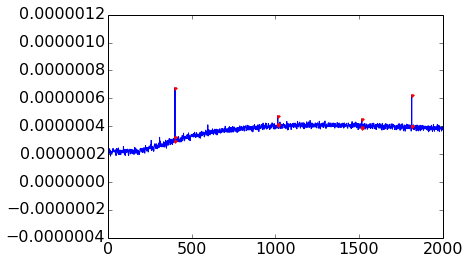

In [492]:
d = lpdetunings[:,0]
fm = deglitch_mask_mad(d,thresh=6,mask_extend=2,window_length=2**8)
#ylim(-.1,1.1)
x = np.arange(d.shape[0])
figure()
plot(x,d)
plot(x[fm],d[fm],'r.')
xlim(0,2000)

In [494]:
tsm =deglitch_mask_mad(detunings[:,0],thresh=6,mask_extend=8,window_length=2**16)

In [519]:
clean = detunings.copy()
clean[tsm,:] = clean[np.roll(tsm,32),:]

In [514]:
pxx,fr = mlab.psd(clean,NFFT=2**20,Fs=256e6/2**14)

In [523]:
dt = clean - clean.mean(1)[:,None]

(1e-19, 1e-16)

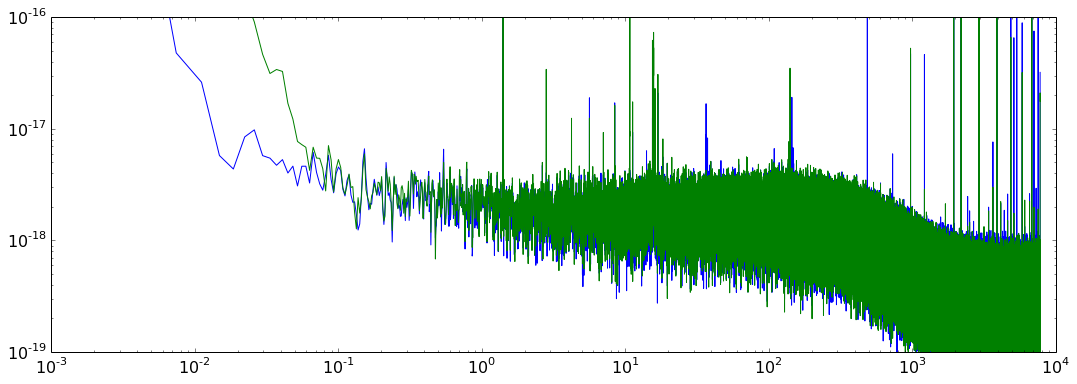

In [538]:
figure(figsize=(18,6))
pxx,fr = mlab.psd(dt[:,0],NFFT=2**22,Fs=256e6/2.**14)
drift,fr = mlab.psd(clean[:,0],NFFT=2**22,Fs=256e6/2.**14)
loglog(fr,pxx)
loglog(fr,drift)
ylim(1e-19,1e-16)

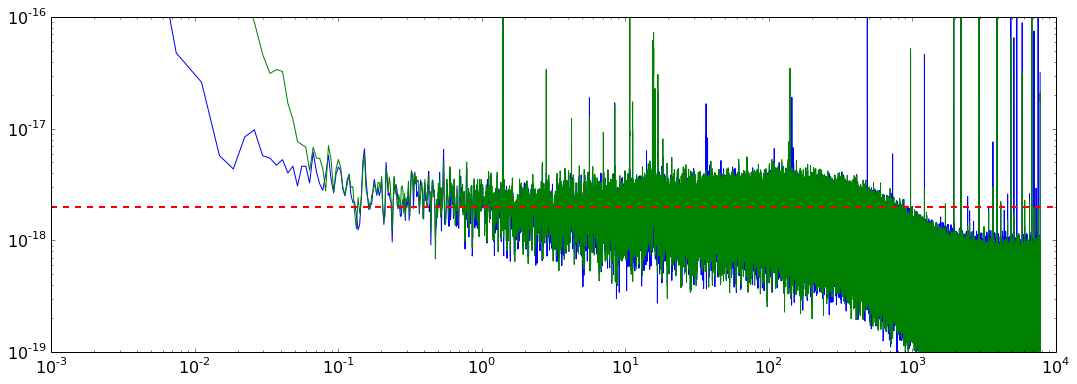

In [540]:
figure(figsize=(18,6))
loglog(fr,pxx)
loglog(fr,drift)
ylim(1e-19,1e-16)
gca().axhline(2e-18,color='r',lw=2,linestyle='--')

(1e-19, 1e-16)

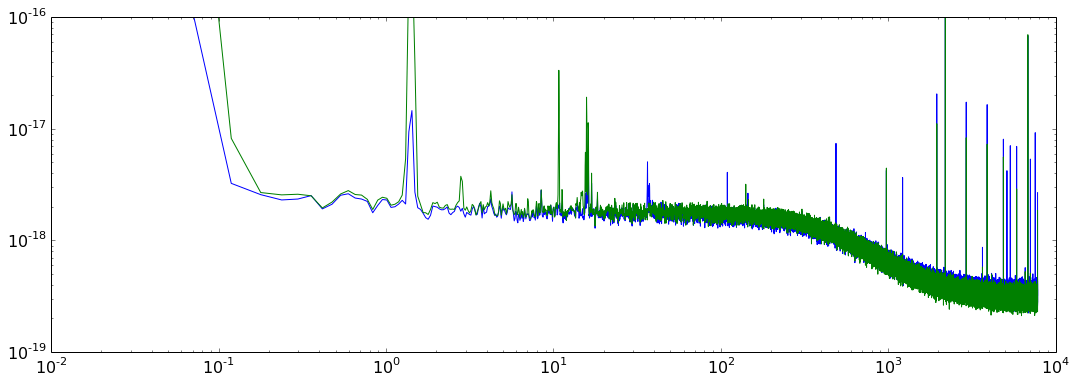

In [535]:
figure(figsize=(18,6))
pxx,fr = mlab.psd(dt[:,0],NFFT=2**18,Fs=256e6/2.**14)
drift,fr = mlab.psd(clean[:,0],NFFT=2**18,Fs=256e6/2.**14)
loglog(fr,pxx)
loglog(fr,drift)
ylim(1e-19,1e-16)

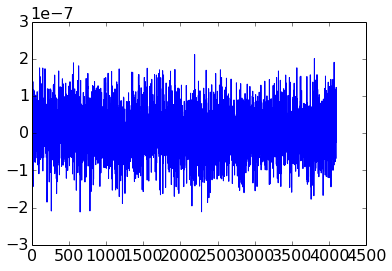

In [530]:
plot(dt[::2**13,0])

In [495]:
tsm.sum()

64150

(67400, 67500)

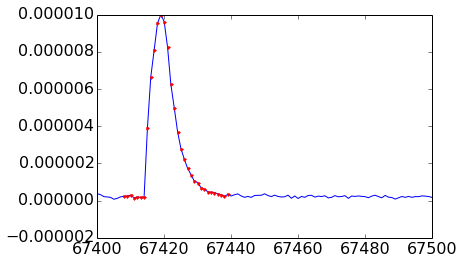

In [508]:
k = 100000
x = arange(k)
plot(x,detunings[:k,0])
plot(x[tsm[:k]],detunings[:k,0][tsm[:k]],'r.')
xlim(67400,67500)

In [493]:
fm.sum()*1./d.shape[0]

0.011871337890625

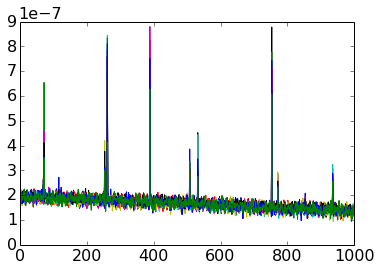

In [476]:
blah = plot(lpdetunings[5000:6000,:])

In [399]:
degl = despike.deglitch_window(lpdetunings[:,0]-lpdetunings.mean(1),2**9,thresh=3)
degl = despike.deglitch_window(degl,2**9,thresh=3)
degl = despike.deglitch_window(degl,2**9,thresh=3)
degl = despike.deglitch_window(degl,2**9,thresh=3)
degl = despike.deglitch_window(degl,2**9,thresh=3)

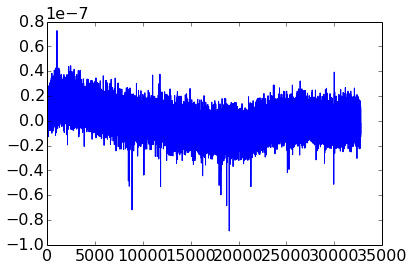

In [400]:
plot(degl)

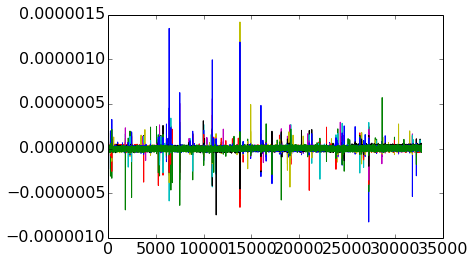

In [386]:
blah = plot(lpdetunings-lpdetunings.mean(1)[:,None]*weights)

In [29]:
lpfs = np.vstack([snm.low_pass_projected_timeseries.real for snm in snms]).T
print lpfs.shape

(8591, 16)


In [310]:
def background(factors):
    return lpfs.mean(1)
def signals(factors):
    return lpfs-background(factors)[:,None]/(1.0*factors)

In [311]:
def residual(factors):
    sig = signals(factors)
    return np.abs(np.std(sig,axis=0).mean())

In [312]:
residual(np.ones(16)*1)

3.6170861797684797

In [254]:
import scipy.optimize

In [263]:
def cb(factors):
    print residual(factors)

In [313]:
result = scipy.optimize.minimize(residual,weights,method='L-BFGS-B',
                                             bounds=[(1e-6,1e6) for x in range(16)])
new_weights = result['x']

In [376]:
result

  status: 0
 success: True
    nfev: 7
     fun: 0.74767012123859644
       x: array([ 1.46291663,  1.4566468 ,  1.30741914,  1.295455  ,  1.16371572,
        1.0983659 ,  1.03745088,  1.02540795,  0.99834965,  0.91528361,
        0.89207507,  0.90015478,  0.84413831,  0.77830392,  0.78205172,
        0.76344658])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([ -3.94129174e-06,  -3.85247390e-06,  -1.95510275e-05,
        -1.76858528e-05,  -7.20534743e-06,   4.55191440e-06,
         1.55431223e-07,   6.43929354e-07,   1.21014310e-06,
         1.38777878e-06,  -4.98046049e-05,   1.75415238e-05,
        -5.64770453e-05,  -5.18474152e-06,   1.36124445e-04,
        -5.27577981e-05])
     nit: 5

In [303]:
weights

array([ 1.46297784,  1.456678  ,  1.30747267,  1.29550436,  1.16377131,
        1.09838881,  1.03745309,  1.02541532,  0.99835813,  0.91531803,
        0.89204339,  0.9001715 ,  0.84412721,  0.77820525,  0.78201911,
        0.76339681])

In [314]:
new_weights-weights

array([ -6.12127714e-05,  -3.11938265e-05,  -5.35320505e-05,
        -4.93629380e-05,  -5.55901963e-05,  -2.29087724e-05,
        -2.20947728e-06,  -7.36666317e-06,  -8.48107948e-06,
        -3.44233868e-05,   3.16814000e-05,  -1.67176202e-05,
         1.11002345e-05,   9.86697507e-05,   3.26057411e-05,
         4.97743205e-05])

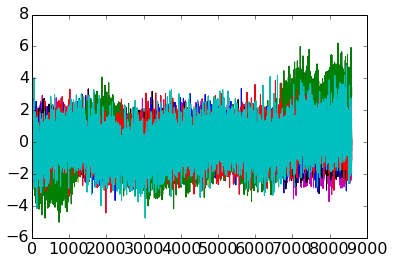

In [316]:
#blah = plot(background(weights)[:,None]/weights)
blah = plot(signals(weights))
blah = plot(signals(new_weights))
#blah = plot(signals(weights*100))

#ylim(0,4)

In [309]:
new_bg = (lpfs*weights).mean(1)

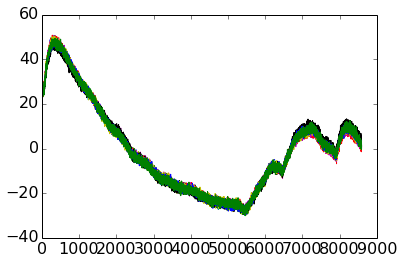

In [317]:
blah = plot(lpfs*new_weights)

In [92]:
bg.shape

(8591,)

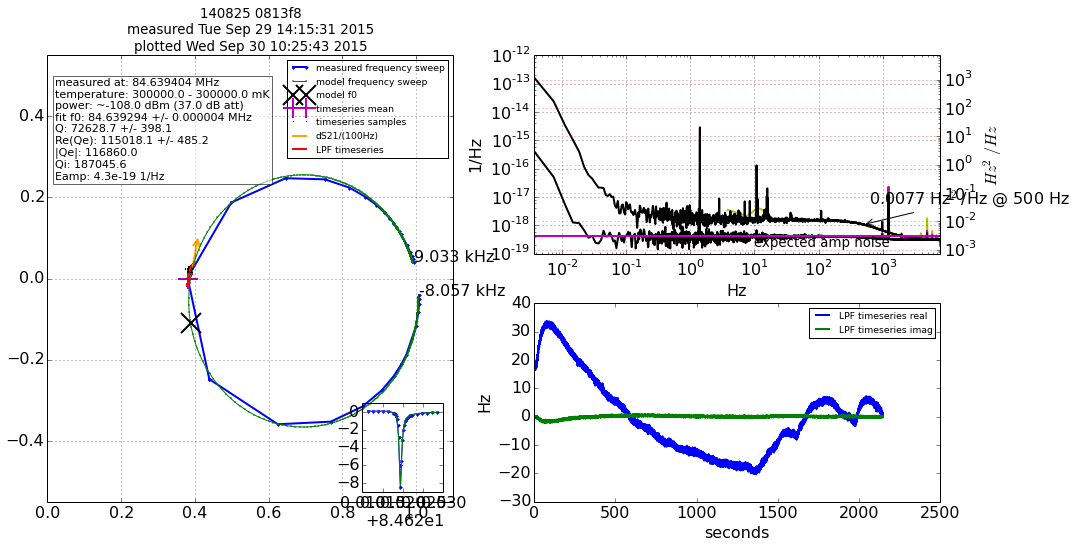

In [16]:
blah = snms[1].plot()

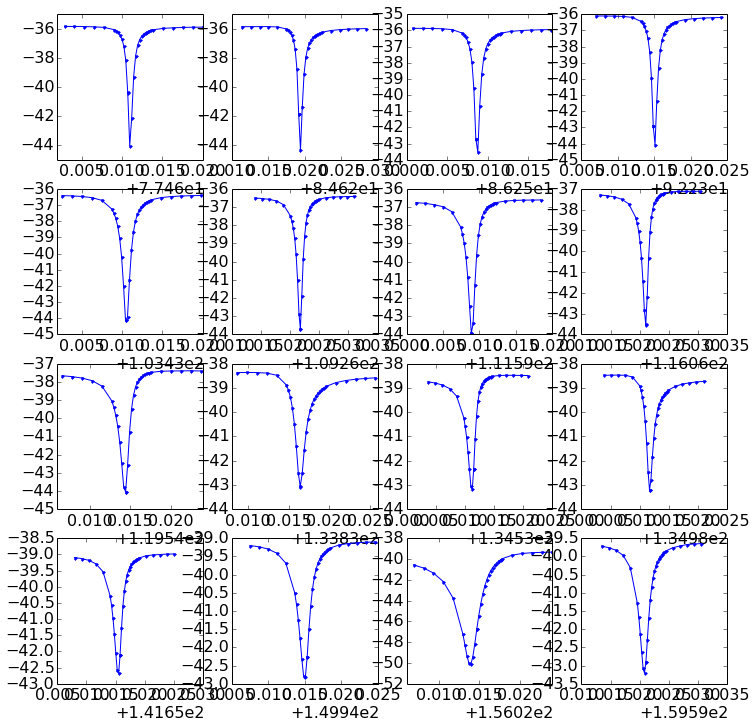

In [17]:
fig,axs= subplots(4,4,figsize=(12,12))
for snm in snms:
    ax = axs.flatten()[snm.resonator_index]
    ax.plot(snm.sweep_freqs_MHz,20*np.log10(np.abs(snm.sweep_s21)),'.-')